# Notebook 06 — Modell-Interpretierbarkeit (Permutation Importance)

Ziel:
- Interpretation des finalen Modells (HistGBR) mit leakage-sicheren Features
- Welche Features beeinflussen die Vorhersage am stärksten?
- Plausibilitätscheck: stimmt das mit Domänenwissen (Distanz/Höhenmeter) überein?

Methode:
- Permutation Importance auf Hold-out (MAE als Score)
- Hinweis: Interpretation ≠ Kausalität


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")

df = pd.read_csv(PATH_MODEL_READY)
TARGET = "moving_time"

# Feature engineering (same as Notebook 05)
df_fe = df.copy()
df_fe["distance_km"] = df_fe["distance"] / 1000.0
df_fe["elev_gain_per_km"] = df_fe["total_elevation_gain"] / (df_fe["distance_km"].replace(0, np.nan))
df_fe["elev_range"] = df_fe["highest_elevation"] - df_fe["lowest_elevation"]
df_fe["elev_gain_per_km"] = df_fe["elev_gain_per_km"].clip(upper=df_fe["elev_gain_per_km"].quantile(0.99))

FEATURES_FE = ["distance", "total_elevation_gain", "highest_elevation", "lowest_elevation",
               "distance_km", "elev_gain_per_km", "elev_range"]
FEATURES_FE = [c for c in FEATURES_FE if c in df_fe.columns]

X = df_fe[FEATURES_FE].copy()
y = df_fe[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (7231, 7) (1808, 7)


Hold-out MAE: 598.4133004984585


,feature,mae_increase_mean_s,mae_increase_std_s
0,distance,3440.961981,62.508140
1,total_elevation_gain,434.197220,16.338440
3,lowest_elevation,159.750648,12.382230
2,highest_elevation,140.276989,5.409809
5,elev_gain_per_km,129.339809,6.002560
6,elev_range,95.125633,7.190628
4,distance_km,0.000000,0.000000


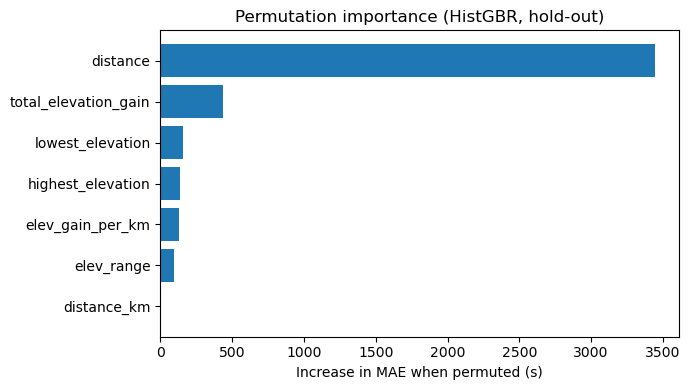

In [4]:
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
    )),
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Hold-out MAE:", mae)

perm = permutation_importance(
    model, X_test, y_test,
    scoring="neg_mean_absolute_error",
    n_repeats=10,
    random_state=SEED,
    n_jobs=-1
)

# For neg_mean_absolute_error: perm.importances_mean is typically NEGATIVE.
# Convert to a positive "increase in MAE (s)".
mae_increase_mean = -perm.importances_mean
mae_increase_std = perm.importances_std

imp = pd.DataFrame({
    "feature": X_test.columns,
    "mae_increase_mean_s": perm.importances_mean,
    "mae_increase_std_s": perm.importances_std,
}).sort_values("mae_increase_mean_s", ascending=False)

display(imp)
imp.to_csv(PATH_DERIVED / "50_permutation_importance_histgbr.csv", index=False)

plt.figure(figsize=(7, 4))
plt.barh(imp["feature"][::-1], imp["mae_increase_mean_s"][::-1])
plt.xlabel("Increase in MAE when permuted (s)")
plt.title("Permutation importance (HistGBR, hold-out)")
savefig("50_permutation_importance_histgbr.png")
plt.show()




## Interpretation der Permutation Importance (Hold-out)

Permutation Importance misst, wie stark sich die Vorhersageleistung verschlechtert, wenn ein Feature zufällig permutiert wird
(= Informationsgehalt des Features für das Modell; keine Kausalität).

**Erkenntnisse:**
- `distance` dominiert deutlich: Die Fahrtdauer wird primär durch die zurückgelegte Strecke bestimmt.
- `total_elevation_gain` ist der zweitstärkste Treiber: Mehr Höhenmeter erhöhen die Fahrtdauer signifikant.
- Höhenlage-Features (`highest_elevation`, `lowest_elevation`) und Profil-Features (`elev_gain_per_km`, `elev_range`) tragen zusätzliche Information bei, sind aber weniger dominant.
- `distance_km` hat keinen Beitrag, weil es redundant zu `distance` ist (gleiche Information in anderer Einheit).

**Implikation:**
Für das finale Modell verwenden wir ein Feature-Set ohne redundante Variablen, um Komplexität zu reduzieren, ohne Performance zu verlieren.


In [5]:
FEATURES_FE_NODUP = [c for c in FEATURES_FE if c != "distance_km"]
X2 = df_fe[FEATURES_FE_NODUP].copy()
y2 = df_fe[TARGET].copy()

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=SEED
)

model2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
    )),
])

model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)

mae2 = mean_absolute_error(y2_test, y2_pred)
print("Hold-out MAE (no distance_km):", mae2)

# Save final feature list for documentation
pd.Series(FEATURES_FE_NODUP, name="final_features_no_leak").to_csv(
    PATH_DERIVED / "52_final_feature_list_no_leak.csv",
    index=False
)


Hold-out MAE (no distance_km): 598.4133004984585


## Fazit Notebook 06

- Die Modellinterpretation bestätigt die erwartete Domänenlogik: Distanz ist der stärkste Prädiktor, gefolgt von Höhenmetern.
- Zusätzliche Features aus dem Höhenprofil liefern Mehrwert, aber deutlich geringer als Distanz/Höhenmeter.
- Redundante Features (z. B. `distance_km`) können entfernt werden, ohne die Modellleistung zu verschlechtern.

**Next step (Notebook 99):**
Zusammenführung der gesamten Pipeline (Problem → Daten → EDA → Preprocessing → Modelle → Evaluation → Interpretation → Diskussion/Fazit)
als finaler, reproduzierbarer Bericht gemäß Anforderungen 1–9.


In [6]:
import joblib

# Train final model on full data with non-redundant feature set
X_final = df_fe[FEATURES_FE_NODUP].copy()
y_final = df_fe[TARGET].copy()

final_model_nodup = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
    )),
])

final_model_nodup.fit(X_final, y_final)

PATH_MODEL = REPO_ROOT / "src" / "models"
PATH_MODEL.mkdir(parents=True, exist_ok=True)

model_path = PATH_MODEL / "histgbr_final_noleak_nodup.joblib"
joblib.dump(final_model_nodup, model_path)
print("Saved final model to:", model_path)

# Save expected feature order (important for inference)
pd.Series(FEATURES_FE_NODUP, name="expected_features").to_csv(
    PATH_MODEL / "histgbr_final_expected_features.csv",
    index=False
)
print("Saved expected features to:", PATH_MODEL / "histgbr_final_expected_features.csv")


Saved final model to: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/src/models/histgbr_final_noleak_nodup.joblib
Saved expected features to: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/src/models/histgbr_final_expected_features.csv
